In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 359 kB/s 
     |████████████████████████████████| 895 kB 72.4 MB/s 
     |████████████████████████████████| 3.3 MB 77.1 MB/s 
     |████████████████████████████████| 596 kB 76.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import re
import json
import string
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel

## Configurations

### Models and Tokenizers

In [3]:
# Configurations
max_len = 384

MODEL_NAME = "bert-base-uncased"
# MODEL_NAME = "bert-base-multilingual-uncased"

VOCAB_NAME = "bert-base-uncased"
# VOCAB_NAME = "bert-base-multilingual-uncased"

TOKENIZER_SAVE_PATH = f"{MODEL_NAME.replace('-','_')}/"

### Language

In [4]:
LANUGUAGE_CODE = 'fr'
RANDOM_SEED = 37

In [5]:
################# CONFIGURATION ############################
TRAINING_TYPE_DICT = {
          1: 'Questions, paragraphs and Models are in English',                         # Train for English Questions
          2: 'Random Questions in English. Paragraph and Models are in English.', 
          3: f'Translated Question is in {LANUGUAGE_CODE}. Paragraph and Model are in English',     # Train for other language translated questions
          4: f'Random Question in {LANUGUAGE_CODE}. Paragraph and Model are in English'
          }

TRAINING_TYPE = 1

In [ ]:
if TRAINING_TYPE == 1:
    LANUGUAGE_CODE = 'en'

### Training

In [29]:
# Model Batch Evaluation Multiple
BATCH_EVAL_MULTIPLE = 10      # Number of steps after which evaluation is done as opposed to end of epoch 

BATCH_SIZE = 128
EPOCHS = 6

### Drive Path

In [ ]:
# MOUNTING DRIVE TO ACCESS DATASET
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# MOUNT PATH
DRIVE_PATH = os.path.join('drive','MyDrive','collab','research', 'bert_qa')

# JSON PATH
TRAIN_PATH = os.path.join(DRIVE_PATH,'train-v2.0.json')
EVAL_PATH = os.path.join(DRIVE_PATH,'dev-v2.0.json')

INPUT_DIR = os.path.join(DRIVE_PATH, 'input')

TRAINSLATED_QUESTIONS_TRAIN_FILE = os.path.join(INPUT_DIR, 'questions_{}_train.tsv'.format(LANUGUAGE_CODE))
TRAINSLATED_QUESTIONS_EVAL_FILE  = os.path.join(INPUT_DIR, 'questions_{}_eval.tsv'.format(LANUGUAGE_CODE))

ENGLISH_QUESTION_COL = 'questions'
TRANSLATED_QUESTION_COL = 'questions_{}'.format(LANUGUAGE_CODE)


# MODEL SAVE PATH
# ENGLISH FINETUNED MODEL
BERT_FINETUNED_SAVE_PATH = os.path.join(DRIVE_PATH, 'english_bert_finetuned.hdf5')

#### Data Paths

In [ ]:
# SQUAD SAVE OBJECT FORMAT
DATA_DIR = os.path.join(DRIVE_PATH, 'data')

SQUAD_OBJ_SAVE_FORMAT = os.path.join(DATA_DIR, '{}_{}_dataset_type_{}_{}.pkl')

In [ ]:
# MODEL EVALUATION OUTPUT FORMAT17
MODEL_EVAL_DIR = os.path.join(DRIVE_PATH, 'eval')
MODEL_EVAL_SAVE_FORMAT = os.path.join(MODEL_EVAL_DIR, f"eval_{LANUGUAGE_CODE}_{MODEL_NAME.replace('-','_')}.tsv")
print(f'Evaluation saved path: {MODEL_EVAL_SAVE_FORMAT}')

In [ ]:
train_translated_df = pd.read_csv(TRAINSLATED_QUESTIONS_TRAIN_FILE, sep='\t')
eval_translated_df = pd.read_csv(TRAINSLATED_QUESTIONS_EVAL_FILE, sep='\t')

### Custom Pretrained Model

In [ ]:
# To use custom pretrained BERT model 
PRETRAINED_MODEL = True
# Pretraining has been done in pytorch
PRETRAINED_IN_PT = False

VOCAB = 'eng'
# VOCAB = 'multilingual'

## Tokenizer

In [7]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained(VOCAB_NAME)
print(f'Using tokenizer: {VOCAB_NAME}')
print(f'Vocabulary size is: {slow_tokenizer.vocab_size}')


if not os.path.exists(TOKENIZER_SAVE_PATH):
    os.makedirs(TOKENIZER_SAVE_PATH)

slow_tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)


# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer(f"{TOKENIZER_SAVE_PATH}vocab.txt", lowercase=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using tokenizer: bert-base-uncased
Vocabulary size is: 30522


## Pretrained Model

This section is for Pretrained Bert finetuning

In [10]:
print(MODEL_NAME)

if PRETRAINED_MODEL:
    PRETRAINED_DIR = os.path.join(DRIVE_PATH, '..','bert_scratch')
    PRE_TRAINED_MODEL_PATH = os.path.join(PRETRAINED_DIR, f"{MODEL_NAME.replace('-','_')}_{VOCAB}_wiki_mlm")
    print(f'Loading custom Pretrained model: {PRE_TRAINED_MODEL_PATH}')
    print(os.path.exists(PRE_TRAINED_MODEL_PATH))
    PRETRAINED_IN_PT = True


bert-base-uncased
Loading custom Pretrained model: drive/MyDrive/collab/research/bert_qa/../bert_scratch/bert_base_uncased_eng_wiki_mlm
True


## Preprocessing Dataset

In [11]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

#### Get Required Questions

In [12]:
# GET QUESTION
def get_required_question(question, data_split_name='train', training_type=1):
  """Update the question in english if required"""
  question = question.strip()
  if training_type == 1:
    return question

  # TO HOLD DATAFRAME OF CONCERN
  data_df = None     
  if data_split_name=='train':  
    data_df = train_translated_df
  else:
    data_df = eval_translated_df
  
  if training_type == 2:
    # FOR RANDOM ENGLISH QUESTION
    random_question = data_df[
                              data_df[ENGLISH_QUESTION_COL]!=question
                            ][ENGLISH_QUESTION_COL].sample(n=1).iloc[0]
    return random_question

  elif training_type == 3:
    # FOR TRANSLATED QUESTION
    target_lang_question = data_df[
                                    data_df[ENGLISH_QUESTION_COL]==question
                                  ][TRANSLATED_QUESTION_COL].iloc[0]
    return target_lang_question

  else:
    # FOR RANDOM TRANSLATED QUESTION
    random_question_trans = data_df[
                              data_df[ENGLISH_QUESTION_COL]!=question
                            ][TRANSLATED_QUESTION_COL].sample(n=1).iloc[0]
    return random_question_trans

#### Create Dataset For Bert Finetuning

In [13]:
def create_squad_examples(raw_data, data_split_name='train'):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                # Update question if required
                question = get_required_question(question, data_split_name, TRAINING_TYPE)
                answer_key = 'answers' 
                if len(qa['answers'])==0:
                    # IF THERE IS NO ANSWER KEY
                    answer_key = 'plausible_answers'
                if len(qa[answer_key])==0:
                    # SKIP IF THERE IS NO PLAUSIBLE ANSWER as well
                    continue    
                answer_text = qa[answer_key][0]["text"]
                all_answers = [_["text"] for _ in qa[answer_key]]
                start_char_idx = qa[answer_key][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples

In [14]:
# CREATE DATASET FOR TRAINING
def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

#### Save and Load Object Helpers

In [15]:
def save_object(python_obj: object, file_path: str):
    """
    Save python object into given file location

    Args:
    -----
        python_obj: python object to be saved
        file_path (str): location to save the numpy array

    Retunrs:
    --------
        None
    """
    with open(
        file_path,
        "wb",
    ) as output:
        pickle.dump(python_obj, output, pickle.HIGHEST_PROTOCOL)

 
def load_object(file_path: str)->object:
    """
    Returns saved python object into given file location

    Args:
    -----
        file_path (str): location to save the numpy array

    Retunrs:
    --------
        python object
    """
    with open(
        file_path,
        "rb",
    ) as input:
        return pickle.load(input)

#### Create Train, Eval Datasets

In [16]:
with open(TRAIN_PATH) as f:
    raw_train_data = json.load(f)

with open(EVAL_PATH) as f:
    raw_eval_data = json.load(f)

# FOR REPRODUCIBILITY  
np.random.seed(RANDOM_SEED)

print(f'For language: {LANUGUAGE_CODE}')
print(f'For model: {MODEL_NAME}')
print(f'For training type {TRAINING_TYPE}: {TRAINING_TYPE_DICT[TRAINING_TYPE]}')

print('------------------------')
train_squad_path = SQUAD_OBJ_SAVE_FORMAT.format('train', LANUGUAGE_CODE, TRAINING_TYPE, f"{MODEL_NAME.replace('-','_')}")
if not os.path.exists(train_squad_path):
    train_squad_examples = create_squad_examples(raw_train_data, 'train')
    print(f'Saving {train_squad_path}')
    save_object(train_squad_examples, train_squad_path)
else:
    print(f'Loading {train_squad_path}')
    train_squad_examples = load_object(train_squad_path)

x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")


eval_squad_path = SQUAD_OBJ_SAVE_FORMAT.format('eval', LANUGUAGE_CODE, TRAINING_TYPE, f"{MODEL_NAME.replace('-','_')}")
if not os.path.exists(eval_squad_path):
    eval_squad_examples = create_squad_examples(raw_eval_data, 'eval')
    print(f'Saving {eval_squad_path}')
    save_object(eval_squad_examples, eval_squad_path)
else:
    print(f'Loading {eval_squad_path}')
    eval_squad_examples = load_object(eval_squad_path)

x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

For language: en
For model: bert-base-uncased
For training type 1: Questions, paragraphs and Models are in English
------------------------
Loading drive/MyDrive/collab/research/bert_qa/data/train_en_dataset_type_1_bert_base_uncased.pkl
130319 training points created.
Loading drive/MyDrive/collab/research/bert_qa/data/eval_en_dataset_type_1_bert_base_uncased.pkl
11858 evaluation points created.


In [17]:
train_squad_examples[2].question

"When did Beyonce leave Destiny's Child and become a solo singer?"

## MODEL

### Custom Pretrained or Original Bert Selection 

In [18]:
if PRETRAINED_MODEL:
    MODEL_NAME = PRE_TRAINED_MODEL_PATH
    print(f'Using custom pretrained model: {MODEL_NAME}')
    PRETRAINED_IN_PT = True

Using custom pretrained model: drive/MyDrive/collab/research/bert_qa/../bert_scratch/bert_base_uncased_eng_wiki_mlm


### Model Architecture

In [30]:
def create_base_model():
    ## BERT encoder
    print(f'Using the model: {MODEL_NAME}')
    encoder = TFBertModel.from_pretrained(MODEL_NAME, from_pt=PRETRAINED_IN_PT)

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    return model

In [31]:
def create_model():
  """
  CREATE REQUIRED RANDOM INIT MODEL OR BERT ENGLISH FINE TUNED
  """
  model = create_base_model()

  if TRAINING_TYPE not in [1,3]:
      print('Using Fine tuned English BERT as base')
      # LOAD WEIGHTS FOR ENGLISH FINETUNED BERT
      model.load_weights(BERT_FINETUNED_SAVE_PATH)
      # FREEZE THE FINETUNED BERT MODEL
      model.trainable = False
      start_logits = layers.Dense(1, name="start_logit", use_bias=False)(model.layers[3].output[0])
      start_logits = layers.Flatten()(start_logits)

      end_logits = layers.Dense(1, name="end_logit", use_bias=False)(model.layers[3].output[0])
      end_logits = layers.Flatten()(end_logits)

      start_probs = layers.Activation(keras.activations.softmax)(start_logits)
      end_probs = layers.Activation(keras.activations.softmax)(end_logits)

      new_model = keras.Model(
          inputs=model.inputs,
          outputs=[start_probs, end_probs],
      )
      model = new_model
  else:
      print('-----------------------------')
      print(f'Finetuning bert model: {MODEL_NAME} using laguage {LANUGUAGE_CODE}')
  
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  optimizer = keras.optimizers.Adam(lr=5e-5)
  model.compile(optimizer=optimizer, loss=[loss, loss])
  
  return model

### Use TPU

In [32]:
# CREATE MODEL
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.120.182.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.120.182.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Using the model: drive/MyDrive/collab/research/bert_qa/../bert_scratch/bert_base_uncased_eng_wiki_mlm


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

-----------------------------
Finetuning bert model: drive/MyDrive/collab/research/bert_qa/../bert_scratch/bert_base_uncased_eng_wiki_mlm using laguage en
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBa

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Vizualize

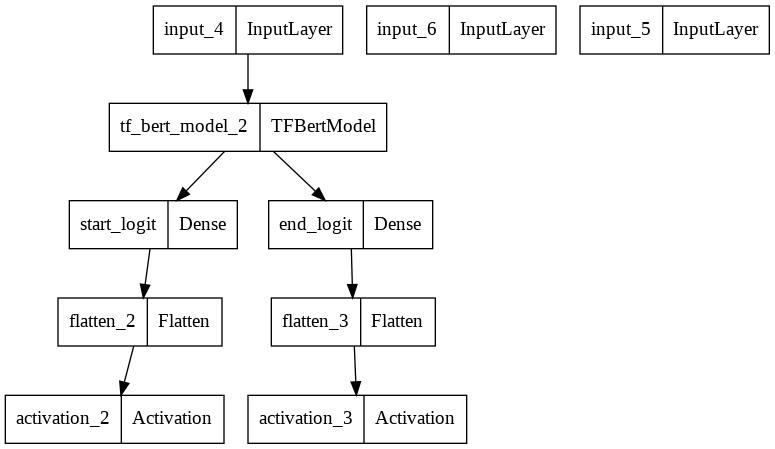

In [33]:
# VISUALIZE MODEL ARCHITECTURE
tf.keras.utils.plot_model(
    model, 
)

## Evaluation Callback

In [34]:
# EVALUATION CALLBACK
class ExactMatch(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval
        self.epoch_cnt = 1
        self.batch_list = []
        self.epoch_list = []
        self.val_acc = []

    def normalize_text(text):
        text = text.lower()

        # Remove punctuations
        exclude = set(string.punctuation)
        text = "".join(ch for ch in text if ch not in exclude)

        # Remove articles
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        text = re.sub(regex, " ", text)

        # Remove extra white space
        text = " ".join(text.split())
        return text

    def on_train_batch_end(self, batch, logs=None):
        batch += 1
        if (batch%BATCH_EVAL_MULTIPLE) == 0:
            # the batch num is a multiple of config param
            # print(batch, self.epoch_cnt)
            pred_start, pred_end = self.model.predict(self.x_eval)
            count = 0
            eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
            for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
                squad_eg = eval_examples_no_skip[idx]
                offsets = squad_eg.context_token_to_char
                start = np.argmax(start)
                end = np.argmax(end)
                if start >= len(offsets):
                    continue
                pred_char_start = offsets[start][0]
                if end < len(offsets):
                    pred_char_end = offsets[end][1]
                    pred_ans = squad_eg.context[pred_char_start:pred_char_end]
                else:
                    pred_ans = squad_eg.context[pred_char_start:]

                normalized_pred_ans = ExactMatch.normalize_text(pred_ans)
                normalized_true_ans = [ExactMatch.normalize_text(_) for _ in squad_eg.all_answers]
                if normalized_pred_ans in normalized_true_ans:
                    count += 1
            acc = count / len(self.y_eval[0])
            self.val_acc.append(f'{acc:.2f}')
            print(f"\nepoch={self.epoch_cnt}, batch={batch}, exact match score={acc:.2f}")
            self.batch_list.append(batch)
            self.epoch_list.append(self.epoch_cnt)

    def on_epoch_end(self, epoch, logs=None):
        # pred_start, pred_end = self.model.predict(self.x_eval)
        # count = 0
        # eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        # for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
        #     squad_eg = eval_examples_no_skip[idx]
        #     offsets = squad_eg.context_token_to_char
        #     start = np.argmax(start)
        #     end = np.argmax(end)
        #     if start >= len(offsets):
        #         continue
        #     pred_char_start = offsets[start][0]
        #     if end < len(offsets):
        #         pred_char_end = offsets[end][1]
        #         pred_ans = squad_eg.context[pred_char_start:pred_char_end]
        #     else:
        #         pred_ans = squad_eg.context[pred_char_start:]

        #     normalized_pred_ans = ExactMatch.normalize_text(pred_ans)
        #     normalized_true_ans = [ExactMatch.normalize_text(_) for _ in squad_eg.all_answers]
        #     if normalized_pred_ans in normalized_true_ans:
        #         count += 1
        # acc = count / len(self.y_eval[0])
        # self.val_acc.append(f'{acc:.2f}')
        # print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")
        self.epoch_cnt += 1

## Train

In [ ]:
# TRAIN MODEL AND EVALUATE
exact_match_callback = ExactMatch(x_eval, y_eval)
hist = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,  # For demonstration, 3 epochs are recommended
    verbose=1,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback],
)

Epoch 1/6


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_32:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>, <tf.Tensor 'cond/Identity_32:0' shape=(None,) dtype=int64>]


   6/1002 [..............................] - ETA: 1:52 - loss: 10.3923 - activation_2_loss: 5.4480 - activation_3_loss: 4.9443WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_train_batch_end` time: 4.4729s). Check your callbacks.


   9/1002 [..............................] - ETA: 1:52 - loss: 9.7388 - activation_2_loss: 5.0745 - activation_3_loss: 4.6643

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 384) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 384) dtype=int64>]



epoch=1, batch=10, exact match score=0.01
  19/1002 [..............................] - ETA: 18:13 - loss: 8.9787 - activation_2_loss: 4.6695 - activation_3_loss: 4.3092
epoch=1, batch=20, exact match score=0.01
  29/1002 [..............................] - ETA: 17:25 - loss: 8.6242 - activation_2_loss: 4.4668 - activation_3_loss: 4.1574
epoch=1, batch=30, exact match score=0.03
  39/1002 [>.............................] - ETA: 16:59 - loss: 8.4100 - activation_2_loss: 4.3560 - activation_3_loss: 4.0541
epoch=1, batch=40, exact match score=0.02
  49/1002 [>.............................] - ETA: 16:37 - loss: 8.2779 - activation_2_loss: 4.2858 - activation_3_loss: 3.9921
epoch=1, batch=50, exact match score=0.02
  59/1002 [>.............................] - ETA: 16:20 - loss: 8.1606 - activation_2_loss: 4.2195 - activation_3_loss: 3.9411
epoch=1, batch=60, exact match score=0.03
  69/1002 [=>............................] - ETA: 16:05 - loss: 8.0872 - activation_2_loss: 4.1758 - activation_

In [ ]:
# if TRAINING_TYPE == 1:
#   # SAVE FINE TUNED BERT MODEL
#   model.save_weights(BERT_FINETUNED_SAVE_PATH)
#   # https://github.com/tensorflow/tensorflow/issues/22837

## Save Evaluation Result 

In [ ]:
# MODEL EVALUATION RESULT

# eval_df = pd.DataFrame(data={'epochs':range(1,len(exact_match_callback.val_acc)+1), 'train_loss': hist.history['loss'], 'eval_acc':exact_match_callback.val_acc})
eval_df = pd.DataFrame(data={'epochs':exact_match_callback.epoch_list, 'batch':exact_match_callback.batch_list, 'eval_acc':exact_match_callback.val_acc})
eval_df.to_csv(MODEL_EVAL_SAVE_FORMAT, sep='\t', index=False)